In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
root_dir = '/content/drive/My Drive/Colab Notebooks/grinch-master'
os.chdir(root_dir)

Mounted at /content/drive


In [ ]:
pip install -r requirements.txt   # install the package we need

# 1.Import package

In [3]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from typing import Callable, Tuple, List
from random import choices
import time
import sklearn
import csv
import string

In [4]:
from model.data_point import DataPoint, VectorDataPoint
from clustering.grinch import Grinch
from linkage.vector import cosine_similarity_for_binary_vector_data_point

In [27]:
#import package for plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from random import sample
from pylab import mpl
from sklearn.manifold import TSNE

# 2.Preprocessing dataset as input
input the dataset for every target word

In [5]:
glovefile='glove.6B.300d.txt'  # glove embedding file
datasetfile='twsi_train.csv'   # twsi train file

In [11]:
class word_embed():
    def __init__(self,glovefile,dataset,embed_size,target_word=None):
        self.glovefile=glovefile
        self.dataset=dataset
        self.embed_size = embed_size
        self.target_word=target_word
    def dataprocess(self):
      # process the datset sentence to split it
        context_words = []  # store the context word
        dataset=self.dataset  # datset 
        target_word=self.target_word  

        csv_file=open(dataset)    
        csvf = csv.reader(csv_file)  
        for line in csvf:
          if (line[0]==target_word):       # we only search the context words for target word
            sentence=line[2].strip('[](),.')
            punctuation_string = string.punctuation           # delete all punctuation
            for j in punctuation_string:
              sentence = sentence.replace(j, '')
            words = [word.lower() for word in sentence.split()]
            for i, word in enumerate(words):
              if word == target_word:
                context_words.extend(words[max(i-5, 0):i])
                context_words.extend(words[i+1:min(i+5, len(words))])
  
        return context_words

    def word_embedding(self,context_words):      # embed the word according to the glove
        glovefile=self.glovefile
        with open(glovefile, encoding='utf-8') as ef:
          embeddings_dict = {}
          for line in ef:
            embeddings_dict[line.split()[0]] = np.array([float(value) for value in line.split()[1:]])

        data_stream=[]          #store the datapoint object  VectorDataPoint.id vector
        for cw in context_words:
          embedding_vector=embeddings_dict.get(cw)
          if embedding_vector is not None:
            dp = VectorDataPoint(np.transpose(np.array(embedding_vector)), str(cw))
            data_stream.append(dp)
          # else:
          #   print(cw)
        return data_stream

In [12]:
target_w=['bank','head','power','principal','stage']   # five target words
data_stream=[]
for i in range(len(target_w)):
  print(target_w[i])
  test=word_embed(glovefile=glovefile,dataset=datasetfile,embed_size=300,target_word=target_w[i])
  list_sentence=[]
  list_sentence=test.dataprocess()
  data_stream.append(test.word_embedding(list_sentence))


print(len(data_stream))
print(len(data_stream[0]))
print(len(data_stream[1]))
print(len(data_stream[2]))
print(len(data_stream[3]))
print(len(data_stream[4]))

bank
head
power
principal
stage
5
348
428
437
428
425


# 3.clustering-Grinch
use the grinch implemetation by https://github.com/Troublor/grinch

## grinch

In [13]:
# parameters settings of Grinch algorithm
single_nn_search = False
k_nn = 20   # number of k neighbors
single_elimination = False,
capping = False
capping_height = 50

navigable_small_world_graphs = False
k_nsw = 50

In [14]:
tree=[]
for i in range(len(data_stream)):
  clustering = Grinch(cosine_similarity_for_binary_vector_data_point, debug=False,
                    single_nn_search=single_nn_search, k_nn=k_nn,
                    single_elimination=single_elimination,
                    capping=capping, capping_height=capping_height,
                    navigable_small_world_graphs=navigable_small_world_graphs, k_nsw=k_nsw)
  start=time.time()
  for dp in data_stream[i]:
    clustering.insert(dp)
  # clustering.dendrogram.print()    # print the tree structure
  end = time.time()
  tree.append(clustering.dendrogram)
  print("clustering time for target_word ",target_w[i], end - start,'s')

clustering time for target_word  bank 51.6153998374939 s
clustering time for target_word  head 77.51373243331909 s
clustering time for target_word  power 75.36498522758484 s
clustering time for target_word  principal 83.45216727256775 s
clustering time for target_word  stage 111.02835011482239 s


## output
print each cluster and the mean vectors for evaluation

In [15]:
list_clustering=[]
for k in range(len(tree)):
  list_clustering.append([tree[k].root.rchild,tree[k].root.lchild])

In [16]:
for m in range(len(list_clustering)):
  print("the clustering result of target word",target_w[m])
  print('cluster1:',list_clustering[m][0])
  print('cluster2:',list_clustering[m][1])
  print('---------------------------------------------------')

the clustering result of target word bank
cluster1: ['tamsui', 'palar', 'rurrenabaque', 'beni', 'gallatin', 'phukan', 'flagstar', 'norddeutsche', 'landesbank', 'girozentrale', 'sadiya', 'kohinoor']
cluster2: ['clearing', 'transformed', 'sunny', 'suited', 'ratings', 'updated', 'marathon', 'hills', 'hill', 'reserve', 'reserve', 'merger', 'port', 'fishing', 'offshore', 'brahmaputra', 'rhine', 'thames', 'thames', 'river', 'river', 'river', 'river', 'river', 'river', 'seine', 'imjin', 'score', 'principal', 'missouri', 'massachusetts', 'massachusetts', 'international', 'system', 'system', 'village', 'situated', 'approximately', 'miles', 'opposite', 'leads', 'don', 'murray', 'co', 'brothers', 'two', 'building', 'peace', 'states', 'united', 'united', 'into', 'extended', 'described', '12', 'gave', 'with', 'with', 'with', 'putting', 'above', 'higher', 'average', 'from', 'own', 'own', 'coming', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', '

In [17]:
def compute_centroid(result):
  #input:every cluster
  size=len(result.string)
  vec_array=np.zeros((size,300))
  j=0
  for w in result:
    v=np.array(w.vector)
    vec_array[j]=v
    j=j+1

  mean_array=np.mean(vec_array,axis=0)
  return mean_array

In [18]:
mean_vector=[]
for c in range(len(list_clustering)):
  mean_vector.append(compute_centroid(list_clustering[c][0]))
  mean_vector.append(compute_centroid(list_clustering[c][1]))

v=np.array(mean_vector)
np.savetxt('online.txt',mean_vector)   # output as txt file

# *4 flat the clustering to output


*   By setting elements number in each cluster to flat the clusters
*   By setting threshold of clusters similariry to flat the clusters



##elements number





In [19]:
def traverse_num(rootnode,num_element=None):
  cluster=[]
  thislevel = [rootnode]
  cluster_dict={}
  count=0
  while thislevel:
    nextlevel = list()
    for n in thislevel:
      if (len(n.string)<=num_element):
        if(len(n.string)>=2):
          cluster.append(n)

      else:
        if n.lchild: nextlevel.append(n.lchild)
        if n.rchild: nextlevel.append(n.rchild)
    thislevel = nextlevel

  return cluster

In [20]:
for ll in range(len(tree)):
  print('Clutering of word',target_w[i])
  res=traverse_num(tree[ll].root,120)
  for s in res:
    print(s.string)

  print("----------------------------------------------------------------")


Clutering of word stage
['tamsui', 'palar', 'rurrenabaque', 'beni', 'gallatin', 'phukan', 'flagstar', 'norddeutsche', 'landesbank', 'girozentrale', 'sadiya', 'kohinoor']
['ltd', 'robbery', 'robbery', 'execute', 'http']
['clearing', 'transformed', 'sunny', 'suited', 'ratings', 'updated', 'marathon']
['allegheny', 'pittsburgh', 'detroit']
['hills', 'hill']
['reserve', 'reserve', 'merger', 'port', 'fishing', 'offshore', 'brahmaputra', 'rhine', 'thames', 'thames', 'river', 'river', 'river', 'river', 'river', 'river', 'seine', 'imjin', 'score', 'principal', 'missouri', 'massachusetts', 'massachusetts']
['investment', 'investment', 'financial', 'banks', 'bank', 'bank', 'bank', 'bank', 'banking', 'deposit', 'commercial', 'corporate', 'companies', 'industry', 'measures', 'strengthen', 'despite']
['east', 'west', 'west', 'north', 'north', 'south', 'south', 'south', 'south', 'south', 'south', 'south', 'south', 'northern']
['system', 'system']
['village', 'situated', 'approximately', 'miles']
['d

##similarity threshold

In [21]:
def traverse_thre(rootnode,threshold):
  clusters=[]
  thislevel = [rootnode]
  while thislevel:
    nextlevel = list()
    for n in thislevel:
      if (len(n.descendants)>=1 and n.lchild and n.rchild):
      #if (len(n.descendants)>=1 or (n.lchild and n.rchild)):
        score=abs(cosine_similarity_for_binary_vector_data_point(n.lchild,n.rchild))
        if (score>threshold):
          clusters.append(n)
        else:
          if n.lchild: nextlevel.append(n.lchild)
          if n.rchild: nextlevel.append(n.rchild)
    thislevel = nextlevel
  return clusters

In [23]:
res2=traverse_thre(tree[0].root,0.6)
for i in range(len(res2)):
  print(res2[i])


['robbery', 'robbery']
['landesbank', 'girozentrale']
['massachusetts', 'massachusetts']
['reserve', 'reserve']
['investment', 'investment', 'financial', 'banks', 'bank', 'bank', 'bank', 'bank', 'banking', 'deposit', 'commercial', 'corporate', 'companies', 'industry', 'measures', 'strengthen']
['east', 'west', 'west', 'north', 'north', 'south', 'south', 'south', 'south', 'south', 'south', 'south', 'south']
['system', 'system']
['thames', 'thames']
['river', 'river', 'river', 'river', 'river', 'river']
['plan', 'plan']
['states', 'united', 'united']
['into', 'extended', 'described', '12', 'gave', 'with', 'with', 'with', 'putting', 'above', 'higher', 'average', 'from', 'own', 'own', 'coming', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 

# *5.Clustering visualization

*   word embedding visualization
*   clustering result visualization
using tsne package to reduce the dimension



## adjust the output to plot

In [26]:
def plot_input(result):
  res=result
  list_word=[]
  list_array=[]
  list_cluster=[]
  dist=0
  list_label=[]
  for i in range(len(res)):
    for w in res[i]:
      word=w.id
      list_word.append(word)
      vec=np.array(w.vector)
      list_array.append(vec)
      clus=i
      list_cluster.append(clus)
  return list_word,list_array,list_cluster
 

In [29]:
'''compute the centroid word for each cluster    '''
def plot_centroid(result):
  list_label=[]
  
  for i in range(len(result)):

    # compute the mean of every cluster
    size=len(result[i].string)
    vec_array=np.zeros((size,300))
    word=' '
    j=0
    dist=float('inf')
    for w in result[i]:
      v=np.array(w.vector)
      vec_array[j]=v
      j=j+1

    mean_array=np.mean(vec_array,axis=0)

   # compute the distance for every point
    for ww in result[i]:
      v1=np.array(ww.vector)
      tmp_dist = np.sqrt(np.sum(np.square(v1 - mean_array)))
      #print(tmp_dist)
      if (tmp_dist<dist):
        dist=tmp_dist
        word=ww.id

    # compute the centroid word for every cluster
    if (word==''):
      word='none'
    list_label.append(word)
  return list_label

## word vector visualization

In [39]:
#rdata=traverse_num(tree[0].root,50)   # bank dataset as an example
rdata=list_clustering[0]     # bank dataset as an example
list_word,list_array,list_cluster=plot_input(rdata)
labels = list_word #
tokens = list_array #

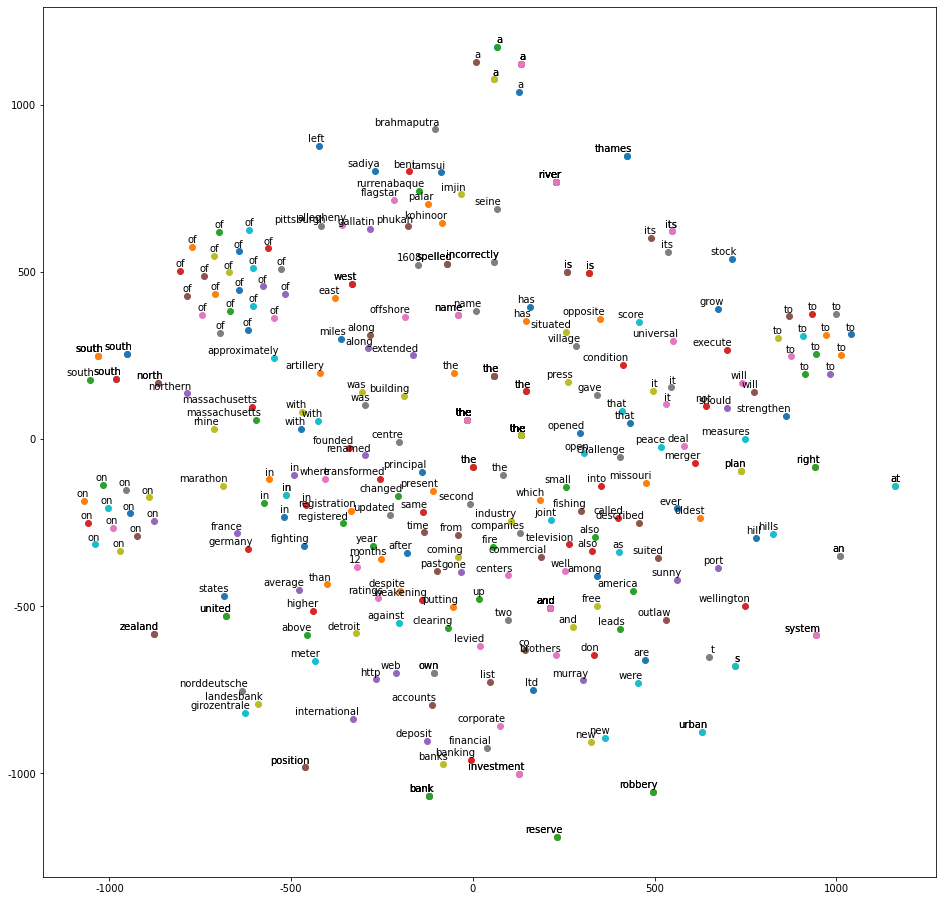

In [40]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)
mpl.rcParams['axes.unicode_minus'] = False #
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16,16))
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
plt.show()

### clustering visualization

In [49]:
def plot_clustering(list_word,list_array,list_cluster):
  tsne = TSNE(n_components=2, random_state=0)
  tsne_obj= tsne.fit_transform(list_array)
  tsne_df = pd.DataFrame({'X':tsne_obj[:,0],'Y':tsne_obj[:,1],'cluster':list_cluster})
  sns.scatterplot(x="X", y="Y",data=tsne_df,hue="cluster");

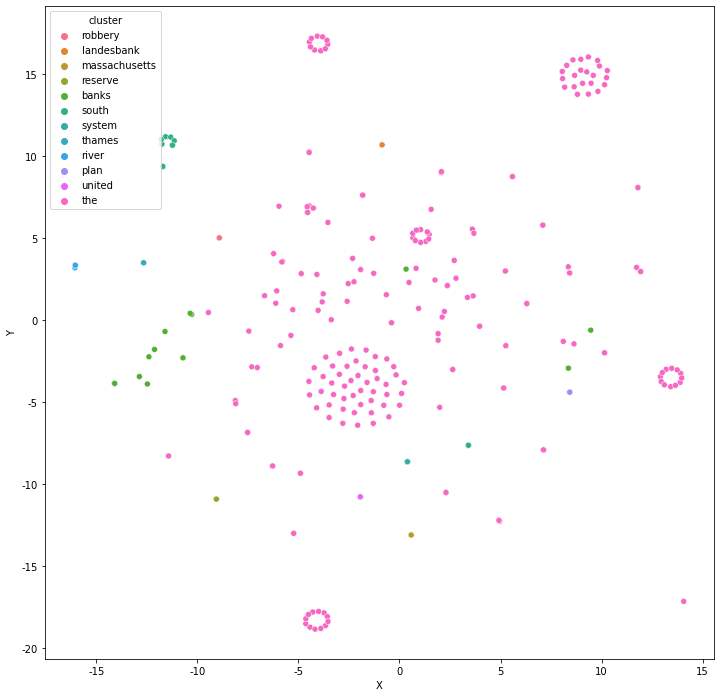

In [52]:
# plot the clustering using word representations
rdata=traverse_thre(tree[0].root,0.6)  # bank dataset as an example
list_word,list_array,list_cluster=plot_input(rdata)
list_label=plot_centroid(rdata)
list_cluster_new=[]
for c in range(len(list_cluster)):
  list_cluster_new.append(list_label[list_cluster[c]])

plt.figure(figsize=(12,12))
plot_clustering(list_word,list_array,list_cluster_new)

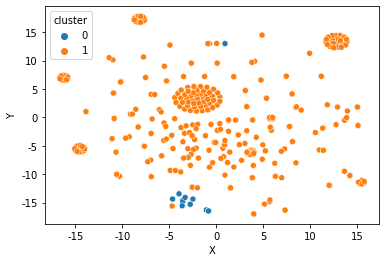

In [53]:
list_word,list_array,list_cluster=plot_input(list_clustering[0])
plot_clustering(list_word,list_array,list_cluster)